In [2]:
from pathlib import Path
import shutil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import fastai.tabular.all as fai_tab
import torch
from torch.utils.data import Dataset, DataLoader

pd.options.display.max_columns = 0

In [3]:
from kaggle import api

comp = "titanic"
path = Path(f"./datasets/{comp}")

if not path.exists():
    api.competition_download_cli(comp, path=path)
    shutil.unpack_archive(str(path/f'{comp}.zip'), str(path))
    (path/f'{comp}.zip').unlink()

In [4]:
df = pd.read_csv(path/"train.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
splits = fai_tab.RandomSplitter(seed=42)(df)
splits

((#713) [788,525,821,253,374,98,215,313,281,305...],
 (#178) [303,778,531,385,134,476,691,443,386,128...])

In [6]:
dls = fai_tab.TabularPandas(df, splits=splits, 
    procs=[fai_tab.Categorify, fai_tab.FillMissing, fai_tab.Normalize],
    cat_names=['Sex', 'Pclass',  'Embarked'],
    cont_names=['Age', 'SibSp', 'Parch', 'Fare'],
    y_names='Survived', y_block=fai_tab.CategoryBlock()
).dataloaders(path=".")

SuggestedLRs(valley=0.02290867641568184)

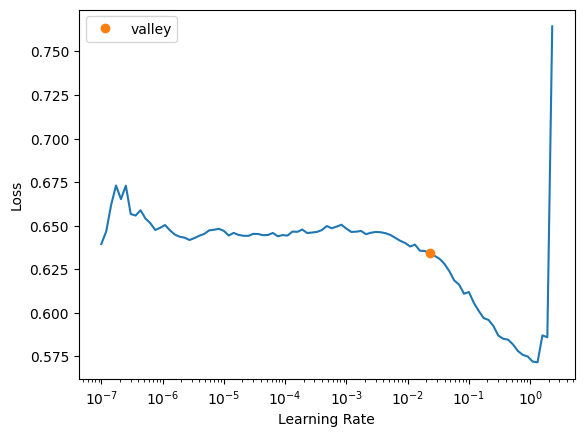

In [9]:
learn = fai_tab.tabular_learner(dls, metrics=fai_tab.accuracy, layers=[10,10])
learn.lr_find()

In [10]:
learn.fit(10, lr=0.03)

epoch,train_loss,valid_loss,accuracy,time
0,0.583216,0.578522,0.702247,00:00
1,0.523149,0.485109,0.797753,00:00
2,0.485544,0.434760,0.792135,00:00
3,0.464162,0.406739,0.825843,00:00
4,0.451803,0.422440,0.820225,00:00
5,0.446653,0.407321,0.797753,00:00
6,0.444558,0.398824,0.820225,00:00
7,0.438392,0.399724,0.831461,00:00
8,0.434348,0.399584,0.837079,00:00
9,0.428511,0.399754,0.814607,00:00


# Manually

Fastai just does too much for us to be able to effectively experiment with inputs and outputs.

Let's do it all manually with Pytorch.

First, we need to clean and encode the data.

In [5]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


## Fill missing values and Categorify

We're just filling missing values with the median or mode and marking if they were filled.

For categorify, we're one-hot encoding the low cardinality columns and making the high card ones just integers.

In [8]:
def clean_data(df: pd.DataFrame):
    df_clean = df.copy()

    df_clean['Age_missing'] = np.where(
        df_clean['Age'].isna(), 1, 0
    )
    df_clean['Age'] = df_clean['Age'].fillna(df['Age'].median())

    df_clean['Cabin_missing'] = np.where(
        df_clean['Cabin'].isna(), 1, 0
    )
    df_clean['Cabin'] = df_clean['Cabin'].fillna(df['Cabin'].mode().iloc[0])

    df_clean['Embarked_missing'] = np.where(
        df_clean['Embarked'].isna(), 1, 0
    )
    df_clean['Embarked'] = df_clean['Embarked'].fillna(df['Embarked'].mode().iloc[0])

    df_clean = pd.get_dummies(df_clean, columns=['Sex', 'Embarked', 'Pclass'])
    # To simplify normalization, just get the codes
    df_clean['Ticket'] = df_clean['Ticket'].astype('category').cat.codes
    df_clean['Cabin'] = df_clean['Cabin'].astype('category').cat.codes

    # Dropping name for now for simplicity, and passenger id is just a unique value we don't need
    df_clean = df_clean.drop('Name', axis=1)
    df_clean = df_clean.drop('PassengerId', axis=1)
    return df_clean


df_clean = clean_data(df)
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Survived          891 non-null    int64  
 1   Age               891 non-null    float64
 2   SibSp             891 non-null    int64  
 3   Parch             891 non-null    int64  
 4   Ticket            891 non-null    int16  
 5   Fare              891 non-null    float64
 6   Cabin             891 non-null    int16  
 7   Age_missing       891 non-null    int64  
 8   Cabin_missing     891 non-null    int64  
 9   Embarked_missing  891 non-null    int64  
 10  Sex_female        891 non-null    bool   
 11  Sex_male          891 non-null    bool   
 12  Embarked_C        891 non-null    bool   
 13  Embarked_Q        891 non-null    bool   
 14  Embarked_S        891 non-null    bool   
 15  Pclass_1          891 non-null    bool   
 16  Pclass_2          891 non-null    bool   
 1

In [5]:
df_clean.head()

,Survived,Pclass,Age,SibSp,Parch,Ticket,Fare,Cabin,Age_missing,Cabin_missing,Embarked_missing,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,A/5 21171,7.2500,B96 B98,0,1,0,False,True,False,False,True
1,1,1,38.0,1,0,PC 17599,71.2833,C85,0,0,0,True,False,True,False,False
2,1,3,26.0,0,0,STON/O2. 3101282,7.9250,B96 B98,0,1,0,True,False,False,False,True
3,1,1,35.0,1,0,113803,53.1000,C123,0,0,0,True,False,False,False,True
4,0,3,35.0,0,0,373450,8.0500,B96 B98,0,1,0,False,True,False,False,True


## Normalize the data

We need to normalize the very high values for the various columns that have values well over single digits like Age and Fare.

This is **extremely** important. I spent a few hours banging my head against the wall trying to figure out why my loss was all over the place and my model wasn't training. Instead of a steady decline in loss as we trained epochs, I was getting a bizarre jagged up/down cycle of loss over time, or sometimes a decrease followed by a spike, and everything in between.

I found an extremely simple version online that basically did the same thing I was doing, but with less data cleaning (just dropped a bunch of columns) that *was* training properly. After running my data through it, I realized that **I did not normalize the columns I had made categorical.** I didn't realize this because `df.describe()` only shows you numeric columns, so `Cabin` and `Ticket`, two high cardinality columns with oridinal numbers going up into the hundreds, were throwing off the training.

After normalizing even the categorical columns, everything trained beautifully.

In [6]:
df_clean.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare,Age_missing,Cabin_missing,Embarked_missing
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.361582,0.523008,0.381594,32.204208,0.198653,0.771044,0.002245
std,0.486592,0.836071,13.019697,1.102743,0.806057,49.693429,0.399210,0.420397,0.047351
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400,0.000000,1.000000,0.000000
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200,0.000000,1.000000,0.000000
75%,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000,0.000000,1.000000,0.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,1.000000,1.000000,1.000000


In [9]:
def normalize_data(df: pd.DataFrame):
    df_clean = df.copy()
    # Log needs +1 or we get invalid values (can't take log of 0)
    df_clean['Fare'] = np.log(df_clean['Fare'] + 1)

    # First version did not normalize Cabin/Ticket and caused poor training!
    # to_normalize = ['Age', 'SibSp', 'Parch', 'Fare']
    to_normalize = ['Age', 'Cabin', 'Ticket', 'SibSp', 'Parch', 'Fare']
    for col in to_normalize:
        df_clean[col] = df_clean[col] / df_clean[col].max()
    
    return df_clean

df_clean = normalize_data(df_clean)

## Create dataloaders

Now that we have our data cleaned, we can create dataloaders.

We need tensors, so we convert everything to floats as appropriate.

We also need a train/test split, which we do randomly in this case.

In [11]:
class TitanicDataset(Dataset):
    def __init__(self, df):
        self.label_col = 'Survived'
        self.df = df.copy()

        for col in self.df.columns:
            if isinstance(self.df[col].dtype, pd.CategoricalDtype):
                self.df[col] = self.df[col].cat.codes.astype('float32')
            else:
                self.df[col] = self.df[col].astype('float32')

        self.df_X = torch.from_numpy(self.df.copy().drop('Survived', axis=1).values)
        # Note: Would probably have been best to unsqueeze here, so I don't have to
        # downstream in the accuracy function.
        self.df_y = torch.from_numpy(self.df.copy()['Survived'].values)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        return self.df_X[idx], self.df_y[idx]

In [25]:
trn_split, val_split = fai_tab.RandomSplitter(seed=42)(df_clean)
# fai_tab.RandomSplitter(seed=42)(df_clean)

# df_clean.iloc[trn_split, :]
ds = TitanicDataset(df_clean)
ds_trn = TitanicDataset(df_clean.iloc[trn_split, :])
ds_val = TitanicDataset(df_clean.iloc[val_split, :])

In [8]:
ds[0]

(tensor([0.2750, 0.1250, 0.0000, 0.7691, 0.3381, 0.3219, 0.0000, 1.0000, 0.0000,
         0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000]),
 tensor(0.))

In [26]:
train_dataloader = DataLoader(ds_trn, batch_size=256, shuffle=True)
val_dataloader = DataLoader(ds_val, batch_size=256, shuffle=True)

In [11]:
df_clean

,Survived,Age,SibSp,Parch,Ticket,Fare,Cabin,Age_missing,Cabin_missing,Embarked_missing,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
0,0,0.2750,0.125,0.000000,0.769118,0.338125,0.321918,0,1,0,False,True,False,False,True,False,False,True
1,1,0.4750,0.125,0.000000,0.876471,0.685892,0.554795,0,0,0,True,False,True,False,False,True,False,False
2,1,0.3250,0.000,0.000000,0.983824,0.350727,0.321918,0,1,0,True,False,False,False,True,False,False,True
3,1,0.4375,0.125,0.000000,0.072059,0.639463,0.376712,0,0,0,True,False,False,False,True,True,False,False
4,0,0.4375,0.000,0.000000,0.694118,0.352955,0.321918,0,1,0,False,True,False,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,0.3375,0.000,0.000000,0.148529,0.422864,0.321918,0,1,0,False,True,False,False,True,False,True,False
887,1,0.2375,0.000,0.000000,0.020588,0.550238,0.205479,0,0,0,True,False,False,False,True,True,False,False
888,0,0.3500,0.125,0.333333,0.992647,0.512205,0.321918,1,1,0,True,False,False,False,True,False,False,True
889,1,0.3250,0.000,0.000000,0.011765,0.550238,0.410959,0,0,0,False,True,True,False,False,True,False,False


## Train the model

Now that we have dataloaders, we can train a model

In [12]:
# For quicker iteration, all setup steps here
df = pd.read_csv(path/"train.csv")
df = normalize_data(clean_data(df))

trn_split, val_split = fai_tab.RandomSplitter(seed=42)(df)
train_dataloader = DataLoader(
    TitanicDataset(df.iloc[trn_split, :]),
    batch_size=256,
    shuffle=True
)
val_dataloader = DataLoader(
    TitanicDataset(df.iloc[val_split, :]),
    batch_size=256,
    shuffle=True
)

## Critical Mistake Costing me HOURS

In addition to not normalizing some of the high cardinality columns, I also messed up the accuracy calculation. It took me ages to identify this issue. I was looking at Jeremy's example implementation so I just assumed it had to be correct. **However**, my labels were formatted slightly differently, which meant I had to adjust their shape before comparing them to the preds.

The most confusing issue is that the model still trained, because even if the labels were incorrectly formatted, **comparison was still possible, just with a totally wrong result**.

After initially grappling with the normalization issue, sometimes my losses were still very noisy so it looked like the model wasn't training, which I thought was confirmed by my very low accuracy. In fact, despite the noisy loss curve, training was occuring, so the low accuracy was just confusing me.

I ended up getting clued in when I submitted test preds to Kaggle and got a 77% accuracy on the test set, way higher than the 50-60% I was falsly getting.

```python
# VERY WRONG BUT STILL WORKS
acc = ((preds > 0.5) == yb).float().mean()

# CORRECT SOLUTION
acc = ((preds > 0.5) == yb.unsqueeze(dim=1)).float().mean()
```

Final Accuracy: 82.58%


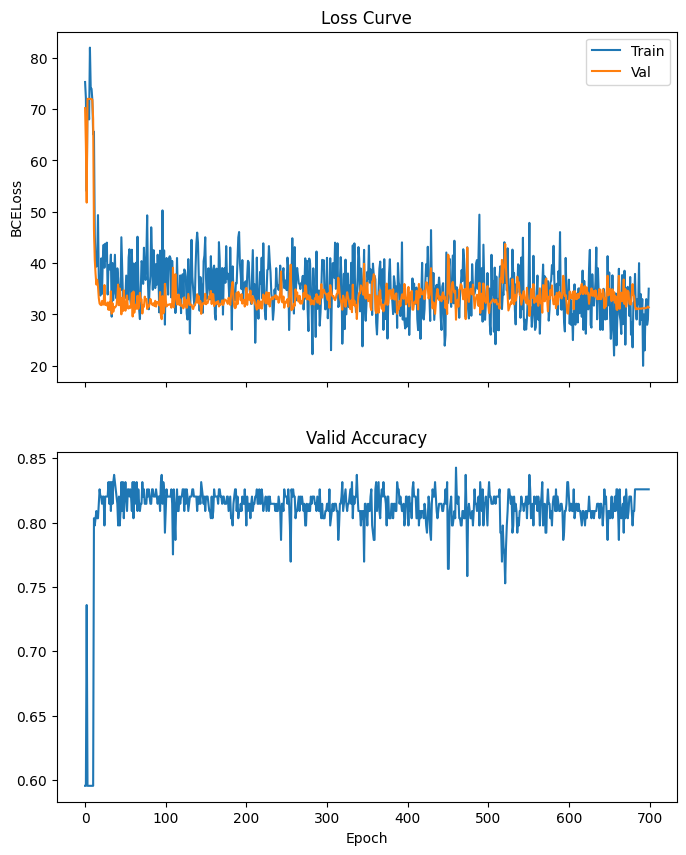

In [13]:
# All but the target column are features
num_features = len(df.columns) - 1
epochs = 700

# More or less replicates fastai's 10, 10, but they seem to have other stuff
# I don't know about yet, like BatchNorm1d and Dropout in addition to  Linear
# So performance will probably be worse, but fine for now
model = torch.nn.Sequential(
    torch.nn.Linear(num_features, 10),
    torch.nn.ReLU(),
    torch.nn.Linear(10, 10),
    torch.nn.ReLU(),
    torch.nn.Linear(10, 1),
    torch.nn.Sigmoid()
)

def loss_fn(Xb: torch.Tensor, yb: torch.Tensor):
    """
    Mean absolute error trains the model pretty much as well as BCELoss.
    Takes many more epochs to train.
    Changing mean to sum makes it train much faster with the same result.
    However, final accuracy is more volatile than BCELoss (ranges from 75% - 85%)
    """
    # return (Xb - yb).abs().mean()
    return (Xb - yb).abs().sum()

# loss_fn = torch.nn.BCELoss()
# loss_fn = manual_loss
optim = torch.optim.SGD(model.parameters(), lr=0.05)
# optim = torch.optim.AdamW(model.parameters(), lr=0.01)

accs = []
losses_trn = []
losses_val = []
def train_loop(Xb: torch.Tensor, yb: torch.Tensor):
    preds = model(Xb)
    loss = loss_fn(preds, yb.float().view(-1,1))
    acc = ((preds > 0.5) == yb.unsqueeze(dim=1)).float().mean()

    loss.backward()
    optim.step()
    optim.zero_grad()

    return loss, acc

def valid_loop(Xb: torch.Tensor, yb: torch.Tensor):
    preds = model(Xb)
    loss = loss_fn(preds, yb.view(-1,1))
    acc = ((preds > 0.5) == yb.unsqueeze(dim=1)).float().mean()
    return loss, acc


for epoch in range(epochs):
    model.train()
    for Xb, yb in train_dataloader:
        loss, acc = train_loop(Xb, yb)
    
    losses_trn.append(loss.item())

    model.eval()
    with torch.inference_mode():
        for Xb, yb in val_dataloader:
            loss, acc = valid_loop(Xb, yb)
        
    losses_val.append(loss.item())
    accs.append(acc)

fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(8,10))
ax0.plot(losses_trn, label='Train')
ax0.plot(losses_val, label='Val')
ax0.legend()
ax0.set(
    title='Loss Curve',
    ylabel='BCELoss'
)

ax1.plot(accs)
ax1.set(
    title='Valid Accuracy',
    xlabel='Epoch'
);

print(f'Final Accuracy: {acc.item()*100:.2f}%')

Final Accuracy: 80.90%


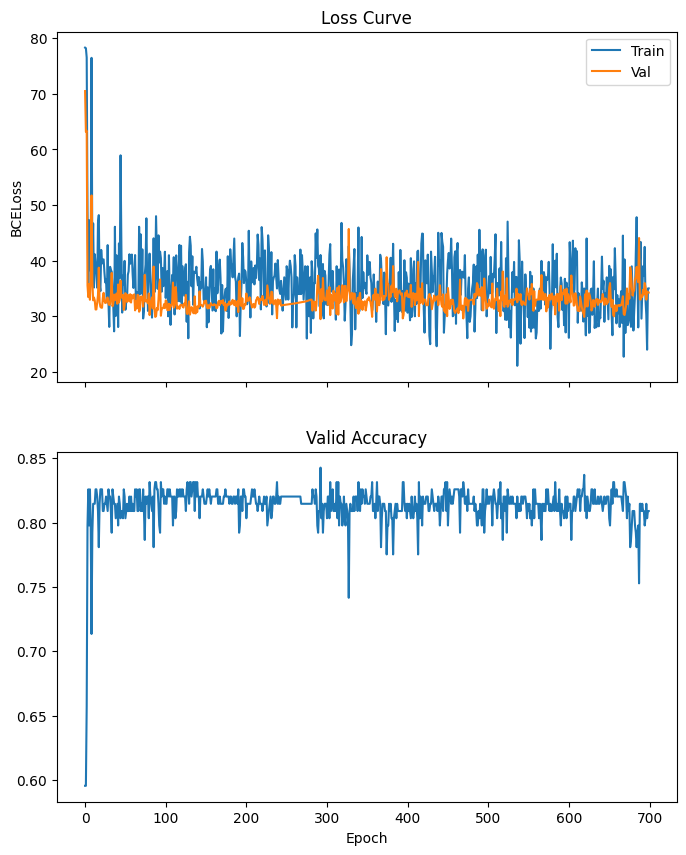

In [14]:
# All but the target column are features
num_features = len(df_clean.columns) - 1
epochs = 700

# More or less replicates fastai's 10, 10, but they seem to have other stuff
# I don't know about yet, like BatchNorm1d and Dropout in addition to  Linear
# So performance will probably be worse, but fine for now
model = torch.nn.Sequential(
    torch.nn.Linear(num_features, 10),
    torch.nn.ReLU(),
    torch.nn.Linear(10, 10),
    torch.nn.ReLU(),
    torch.nn.Linear(10, 1),
    torch.nn.Sigmoid()
)

# def loss_fn(Xb: torch.Tensor, yb: torch.Tensor):
#     """
#     Mean absolute error trains the model pretty much as well as BCELoss.
#     Takes many more epochs to train.
#     Changing mean to sum makes it train much faster with the same result.
#     However, final accuracy is more volatile than BCELoss (ranges from 75% - 85%)
#     """
#     # return (Xb - yb).abs().mean()
#     return (Xb - yb).abs().sum()

def loss_fn(preds: torch.Tensor, yb: torch.Tensor):
    """
    Mean absolute error trains the model pretty much as well as BCELoss.
    Takes many more epochs to train.
    Changing mean to sum makes it train much faster with the same result.
    However, final accuracy is more volatile than BCELoss (ranges from 75% - 85%)
    """
    # return (preds - yb).abs().mean()
    return (preds - yb).abs().sum()

# loss_fn = torch.nn.BCELoss()
# loss_fn = manual_loss
optim = torch.optim.SGD(model.parameters(), lr=0.05)
# optim = torch.optim.AdamW(model.parameters(), lr=0.01)

accs = []
losses_trn = []
losses_val = []
def train_loop(Xb: torch.Tensor, yb: torch.Tensor):
    preds = model(Xb)
    loss = loss_fn(preds, yb.float().view(-1,1))
    acc = ((preds > 0.5) == yb.unsqueeze(dim=1)).float().mean()

    loss.backward()
    optim.step()
    optim.zero_grad()

    return loss, acc

def valid_loop(Xb: torch.Tensor, yb: torch.Tensor):
    preds = model(Xb)
    loss = loss_fn(preds, yb.view(-1,1))
    acc = ((preds > 0.5) == yb.unsqueeze(dim=1)).float().mean()
    return loss, acc


for epoch in range(epochs):
    model.train()
    for Xb, yb in train_dataloader:
        loss, acc = train_loop(Xb, yb)
    
    losses_trn.append(loss.item())

    model.eval()
    with torch.inference_mode():
        for Xb, yb in val_dataloader:
            loss, acc = valid_loop(Xb, yb)
        
    losses_val.append(loss.item())
    accs.append(acc)

fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(8,10))
ax0.plot(losses_trn, label='Train')
ax0.plot(losses_val, label='Val')
ax0.legend()
ax0.set(
    title='Loss Curve',
    ylabel='BCELoss'
)

ax1.plot(accs)
ax1.set(
    title='Valid Accuracy',
    xlabel='Epoch'
);

print(f'Final Accuracy: {acc.item()*100:.2f}%')

In [64]:
df_test_raw = pd.read_csv(path/"test.csv")
df_test = normalize_data(clean_data(df_test_raw))
df_test

,Age,SibSp,Parch,Ticket,Fare,Cabin,Age_missing,Cabin_missing,Embarked_missing,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
0,0.453947,0.000,0.000000,0.419890,0.348997,0.200000,0,1,0,False,True,False,True,False,False,False,True
1,0.618421,0.125,0.000000,0.610497,0.333195,0.200000,0,1,0,True,False,False,False,True,False,False,True
2,0.815789,0.000,0.000000,0.201657,0.379604,0.200000,0,1,0,False,True,False,True,False,False,True,False
3,0.355263,0.000,0.000000,0.406077,0.363449,0.200000,0,1,0,False,True,False,False,True,False,False,True
4,0.289474,0.125,0.111111,0.381215,0.414494,0.200000,0,1,0,True,False,False,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,0.355263,0.000,0.000000,0.737569,0.352955,0.200000,1,1,0,False,True,False,False,True,False,False,True
414,0.513158,0.000,0.000000,0.895028,0.753026,0.293333,0,0,0,True,False,True,False,False,True,False,False
415,0.506579,0.000,0.000000,0.955801,0.338125,0.200000,0,1,0,False,True,False,False,True,False,False,True
416,0.355263,0.000,0.000000,0.607735,0.352955,0.200000,1,1,0,False,True,False,False,True,False,False,True


In [54]:
class TitanicTestDataset(Dataset):
    def __init__(self, df):
        self.df = df.copy()

        for col in self.df.columns:
            if isinstance(self.df[col].dtype, pd.CategoricalDtype):
                self.df[col] = self.df[col].cat.codes.astype('float32')
            else:
                self.df[col] = self.df[col].astype('float32')

        self.df_X = torch.from_numpy(self.df.copy().values)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        return self.df_X[idx]

dl_test = DataLoader(
    TitanicTestDataset(df_test)
)

In [72]:
all_preds = []
for x in dl_test:
    preds = model(x)
    all_preds.append(1 if preds.item() > 0.5 else 0)

df_submit = df_test_raw.copy()
df_submit['Survived'] = all_preds

In [73]:
# Got a 77.5% accuracy on the test set
# On validation, got around 83% usually
df_submit[['PassengerId', 'Survived']].to_csv('titanic_test1.csv', index=False)

## Experiments with other classification stuff like multi-target

This is a multi-target version of the original titanc problem. 
Here I'm both predicting survival (a classification problem) and predicting 
the fare (a regression problem).

This seems to work! It trains and we end up with 82% accuracy on survival, which was always the case. It also reduces the mean absolute error on the fare over time. Unclear how good this ends up since we have no reference point, but it trains!

The key here is to make sure both of the losses are in the same range. If we don't also sigmoid the Fare, we'll end up with Fare overpowering everything, causing survival to fail to train.

Beyond that, we basically just create two separate loss functions, one for each target we are trying to predict, then combine them. This requires some manipulation of the tensors as they come in, e.g. only grabbing the first prediction and the first label for the first target, and only the second pred/label for the second target. If we are doing multi-class classification, this would instead be the first range of num_classes preds/labels. 

Basically, you just grab the data you've decided is associated with each target/label. Which set is associated with which target is arbitrary - you tell the model via the loss function (and the dataset, in how you return the targets).

In [15]:
# Same thing, just don't modify fare
def normalize_data_mc(df: pd.DataFrame):
    df_clean = df.copy()
    # Log needs +1 or we get invalid values (can't take log of 0)
    # df_clean['Fare'] = np.log(df_clean['Fare'] + 1)

    # First version did not normalize Cabin/Ticket and caused poor training!
    # to_normalize = ['Age', 'SibSp', 'Parch', 'Fare']
    to_normalize = ['Age', 'Cabin', 'Ticket', 'SibSp', 'Parch']
    for col in to_normalize:
        df_clean[col] = df_clean[col] / df_clean[col].max()
    
    return df_clean

In [16]:
class TitanicDatasetMC(Dataset):
    def __init__(self, df):
        self.label_col = 'Survived'
        self.df = df.copy()

        for col in self.df.columns:
            if isinstance(self.df[col].dtype, pd.CategoricalDtype):
                self.df[col] = self.df[col].cat.codes.astype('float32')
            else:
                self.df[col] = self.df[col].astype('float32')

        self.df_X = torch.from_numpy(
            self.df.copy().drop('Survived', axis=1).drop('Fare', axis=1).values
        )
        # Now returns a tuple of labels - survived and fare
        self.df_y = torch.from_numpy(self.df.copy()[['Survived', 'Fare']].values)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        return self.df_X[idx], self.df_y[idx]

In [21]:
# For quicker iteration, all setup steps here
df = pd.read_csv(path/"train.csv")
df = normalize_data_mc(clean_data(df))

trn_split, val_split = fai_tab.RandomSplitter(seed=42)(df)
train_dataloader = DataLoader(
    TitanicDatasetMC(df.iloc[trn_split, :]),
    batch_size=256,
    shuffle=True
)
val_dataloader = DataLoader(
    TitanicDatasetMC(df.iloc[val_split, :]),
    batch_size=256,
    shuffle=True
)

In [22]:
for X, y in train_dataloader:
    print(X[0])
    print(y[1])
    break

tensor([0.3500, 0.0000, 0.0000, 0.5750, 0.3219, 1.0000, 1.0000, 0.0000, 0.0000,
        1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000])
tensor([0.0000, 7.8958])


In [19]:
df['Fare'].min(), df['Fare'].max()

(0.0, 512.3292)

Final Accuracy: 80.90%
Final Mean Abs Error: 0.02


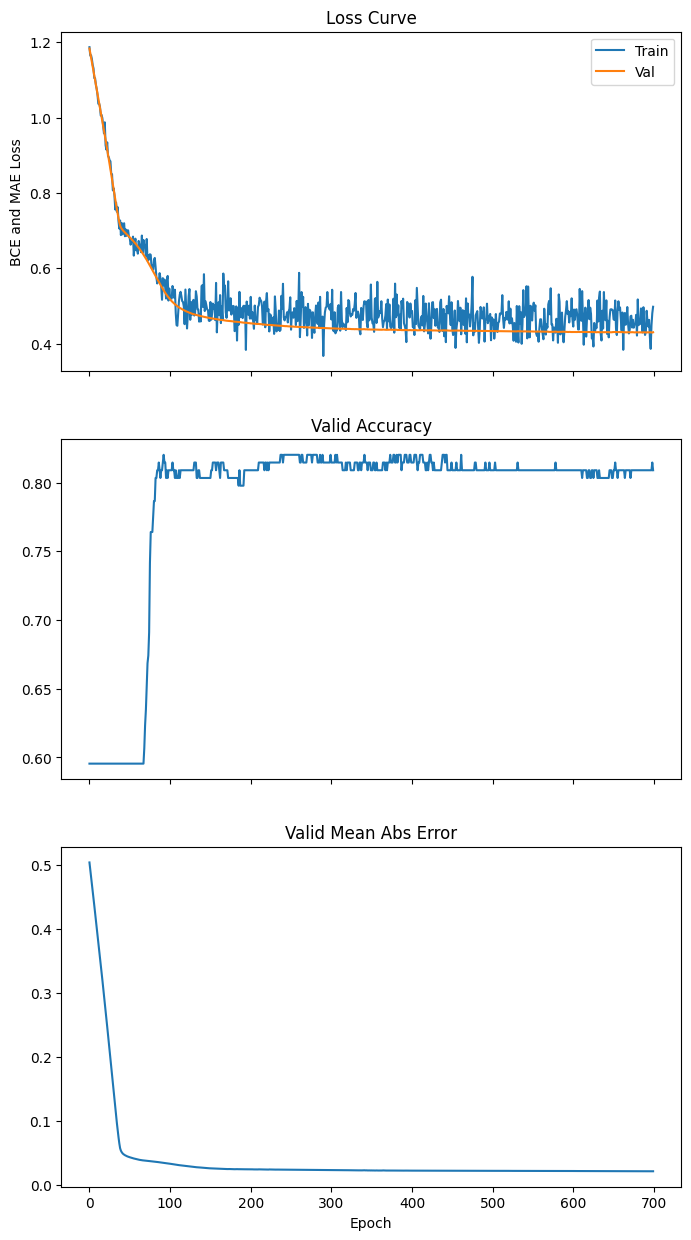

In [23]:
# All but the target column are features
num_features = len(df.columns) - 2
epochs = 700

model = torch.nn.Sequential(
    torch.nn.Linear(num_features, 10),
    torch.nn.ReLU(),
    torch.nn.Linear(10, 10),
    torch.nn.ReLU(),
    torch.nn.Linear(10, 2)
    # torch.nn.Sigmoid()
)

def loss_fn(preds: torch.Tensor, yb: torch.Tensor):
    survival_loss = torch.nn.functional.binary_cross_entropy(
        torch.nn.functional.sigmoid(preds[:, :1]), yb[:, :1]
    )
    fare_loss = torch.nn.functional.l1_loss(
        torch.nn.functional.sigmoid(preds[:, 1:]), 
        torch.nn.functional.sigmoid(torch.log(yb[:, 1:]))
    )
    return survival_loss + fare_loss

# loss_fn = torch.nn.BCELoss()
optim = torch.optim.SGD(model.parameters(), lr=0.05)
# optim = torch.optim.AdamW(model.parameters(), lr=0.01)

accs = []
maes = []
losses_trn = []
losses_val = []
def train_loop(Xb: torch.Tensor, yb: torch.Tensor):
    preds = model(Xb)
    loss = loss_fn(preds, yb.float())
    # acc = ((preds > 0.5) == yb.unsqueeze(dim=1)).float().mean()
    acc = (
        (torch.nn.functional.sigmoid(preds[:, :1]) > 0.5) == yb[:, :1]
    ).float().mean()
    mae = torch.nn.functional.l1_loss(
        torch.nn.functional.sigmoid(preds[:, 1:]), 
        torch.nn.functional.sigmoid(torch.log(yb[:, 1:]))
    )

    loss.backward()
    optim.step()
    optim.zero_grad()

    return loss, acc, mae

def valid_loop(Xb: torch.Tensor, yb: torch.Tensor):
    preds = model(Xb)
    loss = loss_fn(preds, yb.float())
    # acc = ((preds > 0.5) == yb.unsqueeze(dim=1)).float().mean()
    acc = (
        (torch.nn.functional.sigmoid(preds[:, :1]) > 0.5) == yb[:, :1]
    ).float().mean()
    mae = torch.nn.functional.l1_loss(
        torch.nn.functional.sigmoid(preds[:, 1:]), 
        torch.nn.functional.sigmoid(torch.log(yb[:, 1:]))
    )
    return loss, acc, mae


for epoch in range(epochs):
    model.train()
    for Xb, yb in train_dataloader:
        loss, acc, mae = train_loop(Xb, yb)
    
    losses_trn.append(loss.item())

    model.eval()
    with torch.inference_mode():
        for Xb, yb in val_dataloader:
            loss, acc, mae = valid_loop(Xb, yb)
        
    losses_val.append(loss.item())
    accs.append(acc)
    maes.append(mae)

fig, (ax0, ax1, ax2) = plt.subplots(
    nrows=3, ncols=1, sharex=True, figsize=(8,15)
)
ax0.plot(losses_trn, label='Train')
ax0.plot(losses_val, label='Val')
ax0.legend()
ax0.set(
    title='Loss Curve',
    ylabel='BCE and MAE Loss'
)

ax1.plot(accs)
ax1.set(
    title='Valid Accuracy',
);

ax2.plot(maes)
ax2.set(
    title='Valid Mean Abs Error',
    xlabel='Epoch'
);

print(f'Final Accuracy: {acc.item()*100:.2f}%')
print(f'Final Mean Abs Error: {mae.item():.2f}')

## Manual deep learning model with embeddings

In [42]:
dls.cat_names

(#4) ['Sex','Pclass','Embarked','Age_na']

In [43]:

dls.cont_names

(#4) ['Age','SibSp','Parch','Fare']

## View a batch

We can use one_batch to view the shape of what gets passed to our model's `forward` via the fastai dataloader.

In the case of tabular loaders, we get categorical, continuous, and the label. cat, cont gets passed to forward, and label is used in the loss function.

In [59]:
x_cat, x_cont, y = dls.one_batch()
x_cat[:2], x_cont[:2], y[:2]

(tensor([[2, 1, 3, 1],
         [1, 3, 3, 1]]),
 tensor([[ 2.4417, -0.4629, -0.4645,  0.0250],
         [ 1.2087,  0.4616,  4.5345, -0.0842]]),
 tensor([[0],
         [0]], dtype=torch.int8))

## Manipulating the batch items to fit into the model

`x_cat` gives us a batch where each array is a list of indices in the embedding matrix for each item.

In [20]:
print(dls.cat_names)
x_cat[1]

['Sex', 'Pclass', 'Embarked', 'Age_na']


tensor([2, 3, 3, 1])

What we need to do is look up the actual embedding for each of these since that is what we'll be training on.

In [40]:
column_embedding_matrix_idx = 0
item_in_embedding_matrix_idx = 0
test_embeddings[column_embedding_matrix_idx](torch.tensor(item_in_embedding_matrix_idx))

tensor([-0.3582, -0.8790, -1.2074], grad_fn=<EmbeddingBackward0>)

In [53]:
test_embeddings = [torch.nn.Embedding(*emb) for emb in fai_tab.get_emb_sz(dls)]
# We need to stack these up into one tensor
x_emb = torch.stack(
    [torch.stack(
            # Here, idx is the index of the column,
            # so we grab the actual embedding matrix for that column.
            # Then, i is the index of the particular item within the embedding matrix
            [test_embeddings[idx](i) for idx, i in enumerate(x)]
        ) for x in x_cat]
)
x_emb[:2]

tensor([[[-0.7265,  0.5682, -1.0006],
         [-0.9929, -0.6614,  1.7006],
         [ 0.4834,  0.0524,  1.4992],
         [ 0.2328, -1.2158,  2.8345]],

        [[ 0.4123, -0.2202, -1.7519],
         [-2.0971,  0.1009,  0.6100],
         [ 1.9454,  0.3652, -0.2261],
         [ 0.2328, -1.2158,  2.8345]]], grad_fn=<SliceBackward0>)

Now that we have the embedding matrix for each column, we need to combine these with the continuous columns so we can pass it into our model layers.

To do this, we need to reshape the tensor so that all the embeddings are on a single row.

The key idea here is that **each factor in an embedding is treated as a separate, trainable parameter**. In other words, the continuous columns like Age, Fare, etc, get a single parameter, because that encompases the entirety of the information in that column.

However, each categorical column gets an embedding, which is an array of latent factors. Each of these latent factors is then its own parameter. This gives us a set of rich, trainable parameters for each categorical column.

In [51]:
x_emb.shape

torch.Size([64, 4, 3])

In [52]:
x_emb_reshaped = x_emb.reshape((64, 12))
x_emb_reshaped[:2]

tensor([[ 0.1724, -0.7643,  0.3709, -0.5190,  0.0972, -1.5049, -0.5193,  0.8134,
         -0.0343, -1.3440, -1.3025, -0.0280],
        [ 0.7370, -0.2691,  0.0910, -0.7328,  0.0113,  0.4797,  0.5235,  0.0675,
         -0.9669, -1.3440, -1.3025, -0.0280]], grad_fn=<SliceBackward0>)

Now that all of the columns' embeddings are combined into one row of parameters for the model, we can fold in the continuous' parameters so that we have a single, final array for the model to take in.

In [55]:
x_cont[:2]

tensor([[ 0.6693, -0.4629, -0.4645,  3.8072],
        [ 0.2069, -0.4629, -0.4645, -0.4736]])

In [58]:
x_combined_batch = torch.concat((x_emb_reshaped[:2], x_cont[:2]), dim=1)
x_combined_batch[:2]

tensor([[ 0.1724, -0.7643,  0.3709, -0.5190,  0.0972, -1.5049, -0.5193,  0.8134,
         -0.0343, -1.3440, -1.3025, -0.0280,  0.6693, -0.4629, -0.4645,  3.8072],
        [ 0.7370, -0.2691,  0.0910, -0.7328,  0.0113,  0.4797,  0.5235,  0.0675,
         -0.9669, -1.3440, -1.3025, -0.0280,  0.2069, -0.4629, -0.4645, -0.4736]],
       grad_fn=<SliceBackward0>)

In [14]:
df['Sex'].unique()

array(['male', 'female'], dtype=object)

In [13]:
print(dls.cat_names)
fai_tab.get_emb_sz(dls)

['Sex', 'Pclass', 'Embarked', 'Age_na']


[(3, 3), (4, 3), (4, 3), (3, 3)]

In [98]:
class DeepLearningEmbeddings(torch.nn.Module):
    def __init__(self, emb_sz: list[tuple[int, int]], num_cont: int):
        super().__init__()
        # Embedding sizes is a list of tuples containing,
        # for each cat column (in dls.cat_names):
        # (num_unique_vals, recommended_embedding_size)
        # Which is exactly what torch's Embedding requires
        self.embeddings = [torch.nn.Embedding(*emb, device='cuda') for emb in emb_sz]
        
        self.total_emb_factors = 0
        for emb in emb_sz:
            self.total_emb_factors += emb[1]
        
        self.total_params = self.total_emb_factors + num_cont

        self.layers = torch.nn.Sequential(
            torch.nn.Linear(self.total_params, 100),
            torch.nn.ReLU(),
            torch.nn.Linear(100,1),
            torch.nn.Sigmoid()
        )

    def forward(self, x_cat: torch.Tensor, x_cont: torch.Tensor):
        x_emb = torch.stack(
            [torch.stack(
                    # Here, idx is the index of the column,
                    # so we grab the actual embedding matrix for that column.
                    # Then, i is the index of the particular item within the embedding matrix
                    [self.embeddings[idx](i) for idx, i in enumerate(x)]
                ) for x in x_cat]
        )
        x_emb = x_emb.reshape((x_emb.shape[0], self.total_emb_factors))
        x_combined = torch.concat((x_emb, x_cont), dim=1)
        return self.layers(x_combined)

def my_acc(preds, y):
    return ((preds > 0.5) == y).float().mean()

model_emb = DeepLearningEmbeddings(fai_tab.get_emb_sz(dls), len(dls.cont_names))
learn = fai_tab.Learner(
    dls, model_emb, loss_func=fai_tab.BCELossFlat(), metrics=my_acc
)
learn.fit(10, lr=0.03, wd=0.2)

epoch,train_loss,valid_loss,my_acc,time
0,0.570230,0.470716,0.792135,00:00
1,0.511318,0.425686,0.814607,00:00
2,0.478231,0.404000,0.808989,00:00
3,0.458425,0.407419,0.831461,00:00
4,0.448145,0.426627,0.837079,00:00
5,0.440941,0.417155,0.820225,00:00
6,0.435138,0.438807,0.837079,00:00
7,0.430035,0.421206,0.820225,00:00
8,0.422748,0.400339,0.820225,00:00
9,0.417372,0.431999,0.837079,00:00


In [99]:
test_df = pd.read_csv(path/"test.csv")
test_df['Fare'] = test_df['Fare'].fillna(0)
test_dl = learn.dls.test_dl(test_df)
# test_dl.one_batch()
preds, _ = learn.get_preds(dl=test_dl)
preds[:2]

tensor([[0.0772],
        [0.3595]])

In [101]:
test_df['Survived'] = (preds > 0.5).int()
sub_df = test_df[['PassengerId', 'Survived']]
sub_df.to_csv('titanic_sub.csv', index=False)
!head titanic_sub.csv

PassengerId,Survived
892,0
893,0
894,0
895,0
896,0
897,0
898,1
899,0
900,1


In [102]:
api.competition_submit('titanic_sub.csv', 'custom deep learning with embeddings', comp)

100%|██████████| 2.77k/2.77k [00:00<00:00, 9.04kB/s]


Successfully submitted to Titanic - Machine Learning from Disaster